# TRABAJO PRÁCTICO 7 - Aprendizaje No Supervisado

In [484]:
import numpy as np
import matplotlib.pyplot as plt

# Creación del dataset

## Funciones

In [485]:
# Definicion de g(u)

def g (u) :

    if (u < 0.25) :
        values = [0,4*u]
    elif (u < 0.5 ):
        values = [2*u - 0.5, 1.5 - 2*u]
    elif (u < 0.75):
        values = [2*u - 0.5, 2*u - 0.5]
    else: 
        values = [1, 4 - 4*u]
    
    return np.array(values)


## Creación del conjunto de datos

In [486]:
n=200
dim = 2

np.random.seed(509)
U = np.random.rand(n)
Z = np.random.randn(n,dim)

G = np.array([g(u) for u in U])

X = G + 0.05 * Z

print(U.shape)
print(Z.shape)
print(G.shape)
print(X.shape)

(200,)
(200, 2)
(200, 2)
(200, 2)


## Gráficos de los datos y curva representativa del manifold M

(200,)
(200, 2)


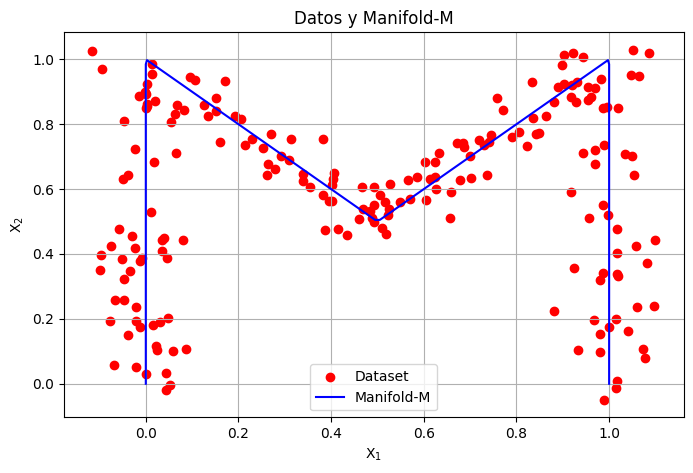

In [487]:
#Generación del Manifold M
u = np.linspace(0, 1, 200)
M = np.array([g(k) for k in u])

print(u.shape)
print(M.shape)

plt.figure(figsize =(8,5))
plt.scatter(X[:, 0], X[:, 1], label = 'Dataset', color='red')
plt.plot(M[:,0], M[:,1], label = 'Manifold-M', color = 'blue')
plt.xlabel(r'$\text{X}_1$')
plt.ylabel(r'$\text{X}_2$')
plt.title('Datos y Manifold-M')
plt.legend()
plt.grid()

# K-Means

## Definición de la clase

In [488]:
class KMeans :
    
    #Inicialización de atributos y declaración de hiperparámetros
    def __init__ (self, n_clusters = 5, max_iter = 100, random_state = 509, tol = 1e-3):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state #Para la elección pseudo-aleatoria de los centroides iniciales
        self.centroids = None
        self.tol = tol
        self.y = None




    ############################################ Entrenamiento
    def fit (self, X):

        if self.random_state:
            np.random.seed(self.random_state)

        #------------------- Se inicializan los centroides, como un elemento aleatorio de X

        n_samples, n_features = X.shape

        #Seleccion sin reposicion de la muestra
        random_idx = np.random.choice(n_samples, self.n_clusters, replace=False) 

        #Se asignan los centroides iniciales como la muestra aleatoria
        self.centroids = X[random_idx] 

        #------------------- Se itera para  calcular los nuevos centroides y obtener las etiquetas

        for i in range(self.max_iter):

            #Se calculan las distancias a los centroides
            distances = self.distance_centr(X) 

            #Se etiqueta cada muestra con un cluster, según el centroide más cercano 
            self.y= np.argmin(distances, axis= 0) 

            #Se recalculan los K centroides, como la media de los datos pertenecientes al mismo cluster
            new_centroids  = np.array([X[self.y == k].mean(axis=0) for k in range(self.n_clusters)]) 
            
            #Se verifica si los centroides actuales no se diferencian mucho del previo como condición de corte (convergencia)
            if np.all(np.linalg.norm(new_centroids - self.centroids, axis=1) < self.tol):
                break

            #Se actualizan los centroides
            self.centroids = new_centroids 

        return self.centroids







    ############################################ Predicción Hard
    def predict(self, X):

        #Se calculan las distancias a los centroides tras el entrenamiento
        distances = self.distance_centr(X)

        #Se retornan las etiquetas correspondientes al centroide más cercano
        return np.argmin(distances, axis= 0) 
    

    def fit_predict(self,X):
        self.fit(X)
        return self.predict(X)

    ############################################ Calcula las distancias de las muestras X a los centroides
    def distance_centr(self, X):
        distances= []
        for k in range(self.n_clusters):
            dis = np.array([np.sqrt(np.sum((X[i,:]-self.centroids[k])**2)) for i in range(X.shape[0])])
            distances.append(dis)

        return np.array(distances)
    
        

## Graficos de los datos separados por clusters

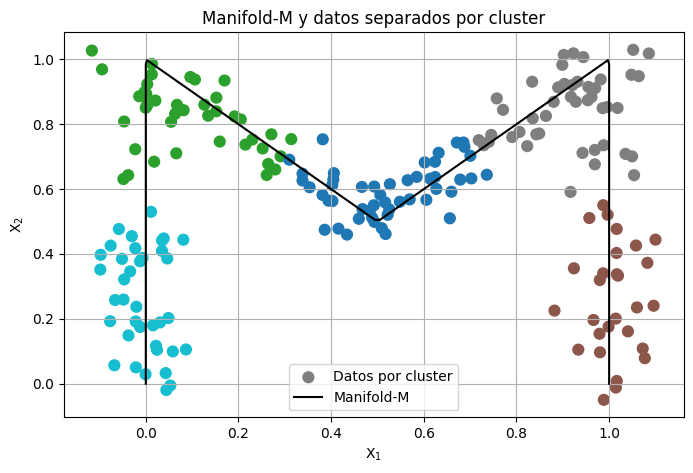

In [489]:
model = KMeans()
model.fit(X)

y_predict = model.predict(X)

plt.figure(figsize=(8,5))
plt.scatter(X[:, 0], X[:, 1], c=y_predict, cmap='tab10', s=60, label = 'Datos por cluster')
plt.plot(M[:,0], M[:,1], label = 'Manifold-M', color = 'black')
plt.title('Manifold-M y datos separados por cluster') 
plt.xlabel(r'$\text{X}_1$')
plt.ylabel(r'$\text{X}_2$')
plt.legend()
plt.grid()


# Algoritmo EM

## Definición de la clase

In [490]:
class EM:

    ########################################################## Inicializar atributos y declaración de hiperparámetros
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4, random_state=509):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.means = None
        self.covariances = None
        self.weights = None
        self.resp = None





    ########################################################## Etapa de entrenamiento
    def fit(self, X):

        np.random.seed(self.random_state)

        n_samples, n_dim = X.shape #Se extraen la cantidad de muestras y las features (2 dimensiones)

        #------------------- Inicialización de los parámetros con K-Means

        kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state, max_iter=self.max_iter)
        
        y = kmeans.fit_predict(X)

        self.means = kmeans.centroids

        #Se calculan las covarianzas de las muestras de cada cluster
        self.covariances = np.array([np.cov(X[y == k].T) for k in range(self.n_clusters)])

        #Se asignan los pesos de cada cluster como la media de las etiquetas de cada uno de ellos
        self.weights = np.array([np.mean(y == k) for k in range(self.n_clusters)])
        

        #------------------- Algoritmo EM

        #Se inicializa la verosimilitud previa como 0
        log_likelihood_old = 0

        
        for _ in range(self.max_iter):
            #-------------------------- Paso E (Expectation)

            self.resp = np.zeros((n_samples, self.n_clusters))

            for k in range(self.n_clusters):

                #Se calcula la probabilidad condicional de que la muesta Xi pertenezca al cluster k, dados los parámetros y la ocurrencia de Xi
                self.resp[:, k] = self.weights[k] * self.multivariate_normal_pdf(
                    X, mean=self.means[k], cov=self.covariances[k]
                )

            #Se normaliza la probabilidad condicional previa, para que sume 1
            self.resp = self.resp / np.sum(self.resp, axis=1, keepdims=True)

            # print(self.resp.shape) #Se obtiene una matriz de n_samples x n_dim

            #-------------------------- Paso M (Maximization)

            #Se calculan la cantidad de puntos de cada cluster de forma "efectiva"
            Nk = np.sum(self.resp, axis=0)

            #Se actualizan los pesos de los clusters
            self.weights = Nk / n_samples

            #Se actualizan las medias. Cada muestra se multiplica por la condicional asociada y se divide por Nk
            self.means = (self.resp.T @ X) / Nk.reshape(-1,1) #Se convierte a un array 2D

            #Se crea un array de ceros para las matrices de covarianza de cada cluster
            self.covariances = np.zeros((self.n_clusters, n_dim, n_dim)) 
            
            #Se actualizan las covarianzas de cada cluster
            for k in range(self.n_clusters):

                #Se calcula la diferencia de las muestras con respecto a la media 
                diff = X - self.means[k] 

                #Se calculan las covarianzas
                self.covariances[k] = (self.resp[:, k].reshape(-1, 1) * diff).T @ diff / Nk[k] 
            

            #Se obtiene la log-verosimilitud, es decir, la suma de los logaritmos de las probabilidades condicionales
            log_likelihood = np.sum(np.log(np.sum([
                self.weights[k] * self.multivariate_normal_pdf(X, self.means[k], self.covariances[k])
                for k in range(self.n_clusters)
            ], axis=0)))

            #Se fija una condición de corte cuando la verosimilitud no cambia en el rango de tolerancia
            if np.abs(log_likelihood - log_likelihood_old) < self.tol:
                break

            #Se actualiza la log-verosimilitud
            log_likelihood_old = log_likelihood

            




    ########################################################## Testeo soft
    def predict_soft(self, X):
        n_samples = X.shape[0]
        resp = np.zeros((n_samples, self.n_clusters))
        
        #Se calculan las probabilidades condicionales como se realizó en el fit
        for k in range(self.n_clusters):
            resp[:, k] = self.weights[k] * self.multivariate_normal_pdf(
                X, mean=self.means[k], cov=self.covariances[k]
            )
        
        #Se normaliza la condicional para que las filas sumen 1
        resp /= resp.sum(axis=1, keepdims=True)
        return resp
    



    
    ########################################################## Testeo hard
    def predict(self, X):
        #Se obtienen las probabilidades de pertenecer a cada uno de los clusters de cada muestra
        resp = self.predict_soft(X)
        
        #Se asigna cada muestra al cluster con mayor probabilidad
        return np.argmax(resp, axis=1)




    ########################################################## fit + predict
    def fit_predict(self, X) : 
        self.fit(X)
        return self.predict(X)
    



    ########################################################## Función que calcula función de densidad de una Gaussiana Multivariable
    def multivariate_normal_pdf(self, x, mean, cov):

        d = mean.shape[0]

        #Se obtiene la inversa de la matriz de covarianza
        cov_inv = np.linalg.inv(cov) 

        #Se obtiene el determinante de la matriz de covarianza
        det_cov = np.linalg.det(cov)
        
        #Se calcula la exponencial
        diff = x - mean
        exponent = -0.5 * np.sum(diff @ cov_inv * diff, axis=1)
        
        #Se calcula la constante de la expresión
        const = 1 / np.sqrt((2 * np.pi) ** d * det_cov)

        return const * np.exp(exponent)

## Gráficos de los datos separados por cluster

Text(0.5, 1.0, 'Fronteras de decisión - Modelo EM')

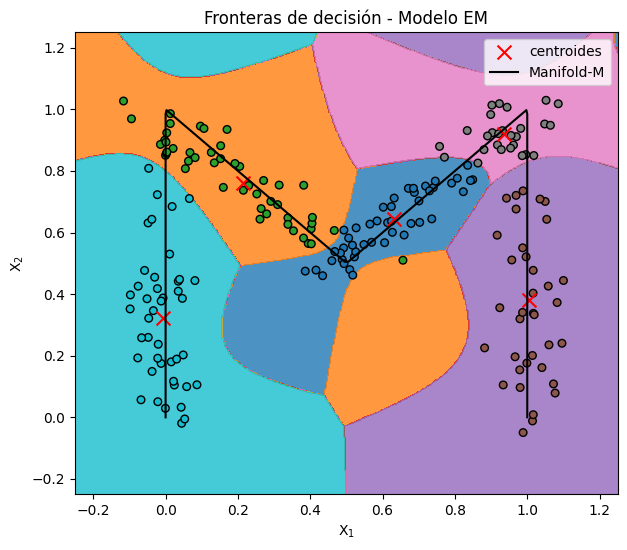

In [491]:
model = EM(n_clusters=5)
model.fit(X)

#Se crea una grilla para los datos
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                        np.linspace(y_min, y_max, 1000))
grid = np.c_[xx.ravel(), yy.ravel()]

#Se obtiene la predicción de los datos
Z = model.predict(grid)
Z = Z.reshape(xx.shape)

#Se grafican las fronteras de decisión
plt.figure(figsize=(7, 6))
plt.contourf(xx, yy, Z, cmap='tab10', alpha=0.8)

#Se grafican los datos y los centroides
plt.scatter(X[:, 0], X[:, 1], c=model.predict(X), s=30, cmap='tab10', edgecolor='k')
plt.scatter(model.means[:, 0], model.means[:, 1], c='red', marker='x', s=100, label='centroides')
plt.plot(M[:,0], M[:,1], label = 'Manifold-M', color = 'black')

plt.ylim([-0.25,1.25])
plt.xlim([-0.25,1.25])

plt.xlabel(r'$\text{X}_1$')
plt.ylabel(r'$\text{X}_2$')

plt.legend()
# plt.grid()

plt.title("Fronteras de decisión - Modelo EM")




# PCA

## Definición de la clase

In [492]:
class PCA:

    #### Inicialización de atributos y declaración de hiperparámetros. Sin aclarar la dimensión del espacio latente.
    def __init__(self,):
        self.mean = None
        self.cov = None
        self.eig_vals = None
        self.eig_vecs = None
        
    #### Entrenamiento. Se entrenan todos los autovectores, sin definir la dimensión latente.
    def fit (self, X):

        self.mean = np.mean(X, axis = 0)

        # print(self.mean.shape)

        X_centered = X - self.mean

        #Se calculan las covarianzas, utilizando las columnas como variables
        self.cov = np.cov(X_centered, rowvar = False) 

        # print(self.cov.shape)

        #Se obtienen los autovalores y autovectores de la matriz de covarianza
        self.eig_vals, self.eig_vecs = np.linalg.eigh(self.cov)

        #Se obtienen los índices de los autovalores ordenados de mayor a menor
        idx = np.argsort(self.eig_vals) #El orden es de menor a mayor
        idx = idx [: : -1] #Se invierte el orden

        #Se ordenan los autovalores de mayor a menor y se ordenan en sintonía los autovectores
        self.eig_vals = self.eig_vals[idx]
        self.eig_vecs = self.eig_vecs[:, idx]

        # print(self.eig_vals.shape)
        # print(self.eig_vecs.shape)


    #### Transforma el espacio original al espacio latente de dimensión k.
    def transform(self, X, k=1):

        X_centered = X - self.mean

        w = self.eig_vecs[:, :k] #Se toman los primeros k autovectores

        X_transformed = X_centered @ w #Se calculan los datos transformados

        return X_transformed


    #### Transforma del espacio latente al espacio original.
    def inverse_transform(self, U, k=1):
        w = self.eig_vecs[:, :k]
        return U @ w.T + self.mean


    #### fit+transform
    def fit_transform (self, X, k=1):
        self.fit(X)
        return self.transform(X,k)


In [493]:
#Testing
model = PCA()

model.fit(X)

x_tr = model.transform(X)

x = model.inverse_transform(x_tr)

x_tr2 = model.fit_transform(X)

print(x_tr.shape)
print(x.shape)
print(x_tr2.shape)

(200, 1)
(200, 2)
(200, 1)


## Entrenamiento y valores extremos de la proyección

In [494]:
#Separación en clusters con EM
em_model = EM (n_clusters= 4, max_iter=500)
y_pred_em = em_model.fit_predict(X)


#Se entrena un PCA para cada cluster
pcas = []
for k in range(em_model.n_clusters):
    X_k = X[y_pred_em == k] 
    pca_k = PCA() 
    pca_k.fit(X_k)
    pcas.append(pca_k)

#Se obtienen los valores extremos de la proyección sobre la recta
mins=[]
maxs= []

for k, pca_k in enumerate(pcas):
    X_k = X[y_pred_em == k]
    proj = pca_k.transform(X_k) #Proyección 1D
    mins.append(proj.min())
    maxs.append(proj.max())
    print(f'cluster: {k} --> min={mins[k]}            max = {maxs[k]}')

mins=np.array(mins,ndmin = 2).T
maxs=np.array(maxs,ndmin = 2).T

# print(mins.shape)
# print(maxs.shape)

cluster: 0 --> min=-0.5327287322703376            max = 0.39534549821873133
cluster: 1 --> min=-0.3424863841256364            max = 0.48857331725456105
cluster: 2 --> min=-0.4429526820116817            max = 0.45916232298842896
cluster: 3 --> min=-0.4620907729728995            max = 0.4214367299993873


## Graficos de los manifold reconstruidos

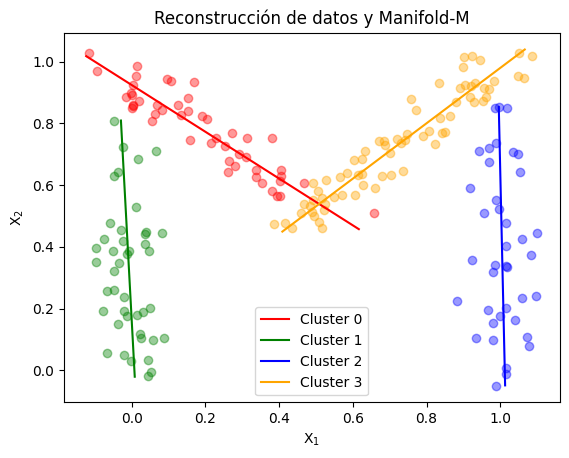

In [495]:
colors=['r','g','b','orange']

#Se grafican los datos para cada cluster
for k in np.unique(y_pred_em):
    X_k = X[y_pred_em == k]
    plt.scatter(X_k[:, 0], X_k[:, 1], color=colors[k], alpha=0.4)

#Se grafican las rectas reconstruidas, asociadas a cada cluster
for k, pca_k in enumerate(pcas):
    #Se generan valores a partir de los valores extremos para cada cluster
    z = np.linspace(mins[k], maxs[k], 100).reshape(-1, 1)
    
    #Se reconstruye la recta de cada cluster
    manifold = pca_k.inverse_transform(z)
    
    plt.plot(manifold[:, 0], manifold[:, 1], color=colors[k], label=f'Cluster {k}')

plt.title('Reconstrucción de datos y Manifold-M')
plt.xlabel(r'$\text{X}_1$')
plt.ylabel(r'$\text{X}_2$')
plt.legend()
plt.show()